In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import seaborn as sns
import os,warnings,datetime

import pandas as pd
import tensorflow as tf

from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,LSTM,Conv2D

warnings.filterwarnings('ignore')
sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('Data\\flares.csv',infer_datetime_format=True,index_col='flare')

In [3]:
df['start.date'] = pd.to_datetime(df['start.date'],infer_datetime_format=True)
df['start.time'] = pd.to_datetime(df['start.time'],infer_datetime_format=True)
df['peak'] = pd.to_datetime(df['peak'],infer_datetime_format=True)
df['end'] = pd.to_datetime(df['end'],infer_datetime_format=True)

In [4]:
df['flag.1'] = df['flag.1'].astype('category').cat.codes
df['flag.2'] = df['flag.2'].astype('category').cat.codes
df['flag.3'] = df['flag.3'].astype('category').cat.codes
df['flag.4'] = df['flag.4'].astype('category').cat.codes
df['flag.5'] = df['flag.5'].astype('category').cat.codes

In [5]:
energy_dict = {}
for k in range(len(df['energy.kev'].astype('category').cat.categories)):
    energy_dict[k] = df['energy.kev'].astype('category').cat.categories[k]
df['energy.kev'] = df['energy.kev'].astype('category').cat.codes

In [6]:
df.corr().abs()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
duration.s,1.000000,0.275545,0.262290,0.337745,0.001489,0.012441,0.003523,0.000321,0.298566,0.198532,0.085810,0.028758,0.186190
peak.c/s,0.275545,1.000000,0.839720,0.266388,0.000037,0.000051,0.014031,0.002531,0.125173,0.000384,0.031944,0.032260,0.042314
total.counts,0.262290,0.839720,1.000000,0.134617,0.000385,0.000076,0.002893,0.000741,0.112571,0.009641,0.032140,0.030822,0.023789
energy.kev,0.337745,0.266388,0.134617,1.000000,0.008894,0.002583,0.098998,0.014545,0.330958,0.110318,0.074020,0.042032,0.132734
x.pos.asec,0.001489,0.000037,0.000385,0.008894,1.000000,0.336335,0.332592,0.045235,0.013527,0.012857,0.009124,0.007102,0.004284
y.pos.asec,0.012441,0.000051,0.000076,0.002583,0.336335,1.000000,0.633313,0.011008,0.014163,0.027912,0.028158,0.033411,0.037312
radial,0.003523,0.014031,0.002893,0.098998,0.332592,0.633313,1.000000,0.026130,0.042729,0.003715,0.014849,0.010577,0.015697
active.region.ar,0.000321,0.002531,0.000741,0.014545,0.045235,0.011008,0.026130,1.000000,0.004324,0.068476,0.017411,0.012346,0.000498
flag.1,0.298566,0.125173,0.112571,0.330958,0.013527,0.014163,0.042729,0.004324,1.000000,0.229572,0.187142,0.166501,0.121564
flag.2,0.198532,0.000384,0.009641,0.110318,0.012857,0.027912,0.003715,0.068476,0.229572,1.000000,0.179639,0.357919,0.588770


In [7]:
df.describe()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
count,113942.000000,113942.000000,1.139420e+05,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000,113942.000000
mean,493.051728,212.321532,3.772013e+05,4.901933,-9.752181,-43.129812,689.528892,979.922926,0.167357,5.449044,6.043092,7.544128,64.120974
std,433.389295,833.776871,3.071203e+06,1.969172,757.017401,404.547666,513.203089,1350.484625,0.652450,3.874414,4.355347,4.415791,70.797191
min,8.000000,0.000000,8.000000e+00,0.000000,-10012.000000,-10005.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,212.000000,28.000000,2.292000e+04,6.000000,-704.000000,-249.000000,469.000000,0.000000,0.000000,2.000000,2.000000,8.000000,-1.000000
50%,364.000000,53.000000,5.857400e+04,6.000000,0.000000,-75.000000,759.000000,687.000000,0.000000,3.000000,9.000000,9.000000,-1.000000
75%,628.000000,144.000000,1.794420e+05,6.000000,706.000000,198.000000,946.000000,1543.000000,0.000000,10.000000,9.000000,11.000000,147.000000
max,4444.000000,113156.000000,4.355501e+08,8.000000,1002.000000,1012.000000,14154.000000,9999.000000,4.000000,15.000000,16.000000,18.000000,161.000000


In [8]:
df = df.sort_values(by='start.date')

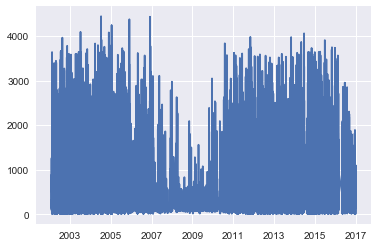

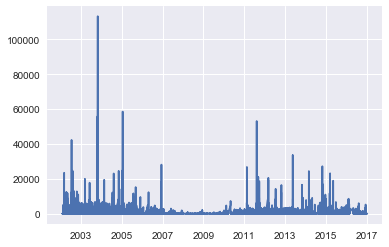

In [9]:
plt.plot(df['start.date'].values,df['duration.s'].values)
plt.show()

plt.plot(df['start.date'].values,df['peak.c/s'].values)
plt.show()

In [10]:
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools

In [11]:
km = KMeans(n_clusters=8)

df_c = df.select_dtypes(exclude=['datetime'])

In [12]:
df_n = StandardScaler().fit_transform(df_c)

In [13]:
clust = km.fit(df_n)
df.insert(3,'Labels',clust.labels_)
df['Labels'].value_counts()

3    35243
5    34893
2    20518
0    17768
4     5231
1      153
7      127
6        9
Name: Labels, dtype: int64

In [14]:
pca0 = PCA(n_components=2)
df_pca = pca0.fit_transform(df_n)

df.insert(0,'pca0',df_pca[:,0])
df.insert(1,'pca1',df_pca[:,1])

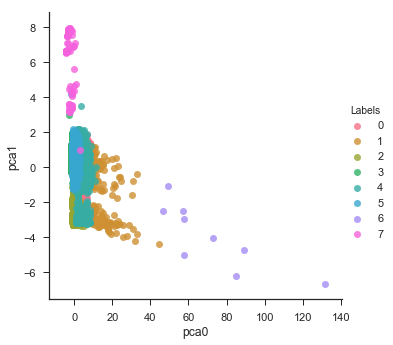

In [15]:
sns.set_context('notebook',font_scale=1.1)
sns.set_style('ticks')
sns.lmplot('pca0','pca1',data=df,fit_reg=False,hue='Labels')

In [16]:
print(pca0.explained_variance_ratio_)

[0.18264852 0.16586493]


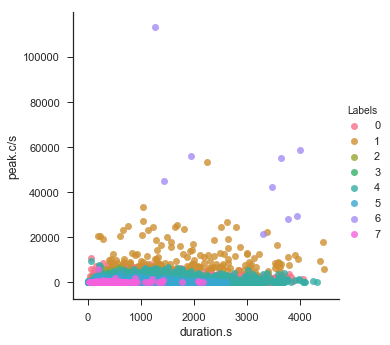

In [19]:
sns.set_context('notebook',font_scale=1.1)
sns.set_style('ticks')
sns.lmplot('duration.s','peak.c/s',data=df,fit_reg=False,hue='Labels')

In [20]:
dff = pd.DataFrame(df['start.date'].value_counts())
dff = dff.sort_index()

<StemContainer object of 3 artists>

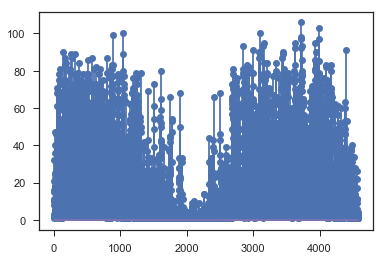

In [21]:
plt.stem(dff['start.date'].values)

In [22]:
deltatime = (df['peak']-df['start.time'])
df.insert(5,'TimeToPeak.s',pd.to_timedelta(deltatime).dt.seconds)

In [23]:
dfp = df[['start.date',
          'TimeToPeak.s',
          'duration.s',
          'peak.c/s',
          'total.counts',
          'energy.kev',
          'flag.1','flag.2','flag.3','flag.4','flag.5']]

In [24]:
pca1 = PCA(n_components=3)
predPCA = pca1.fit_transform(dfp.select_dtypes(exclude=['datetime']))
print(pca1.explained_variance_ratio_)

[9.99999955e-01 2.35840547e-08 1.87295236e-08]


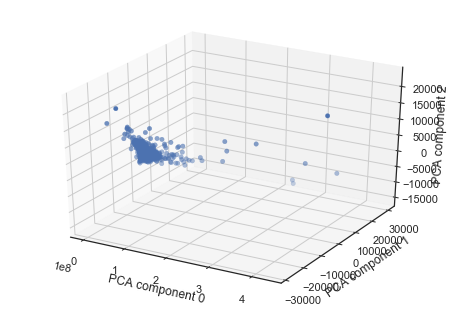

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(predPCA[:,0],predPCA[:,1],predPCA[:,2])
ax.set_xlabel('PCA component 0')
ax.set_ylabel('PCA component 1')
ax.set_zlabel('PCA component 2')

plt.show()

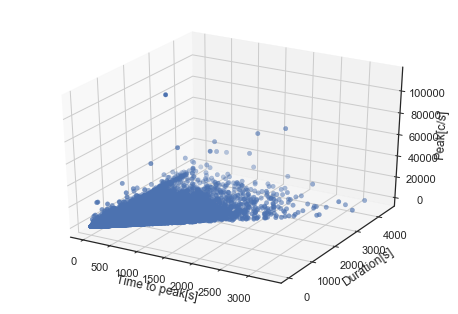

In [26]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(dfp['TimeToPeak.s'].values,dfp['duration.s'].values,dfp['peak.c/s'].values)
ax.set_xlabel('Time to peak[s]')
ax.set_ylabel('Duration[s]')
ax.set_zlabel('Peak[c/s]')

plt.show()

In [27]:
from scipy import fftpack
from sklearn import preprocessing

dff = dff.rename(columns={'start.date':'Count'})

In [28]:
ct_norm = preprocessing.scale(dff['Count'].values)

In [29]:
# x-axis: np.arange(0,len(yfft)-1)*Fs/N -> Fs = 1 day, N = len(yfft) 

CT_NORM = fftpack.fft(ct_norm)
f = fftpack.fftfreq(len(ct_norm))*1

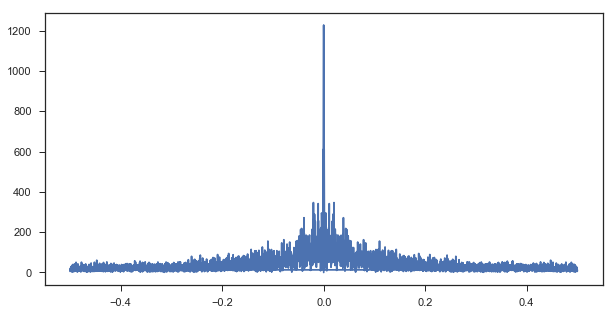

In [30]:
plt.figure(figsize=(10,5))
plt.plot(f,np.abs(CT_NORM))

In [31]:
dfp.head()

,start.date,TimeToPeak.s,duration.s,peak.c/s,total.counts,energy.kev,flag.1,flag.2,flag.3,flag.4,flag.5
flare,,,,,,,,,,,
2021213,2002-02-12,222,712,136,167304,1,1,10,-1,-1,-1
2021228,2002-02-12,58,288,7,9504,6,1,10,10,11,-1
2021355,2002-02-13,130,1260,56,91896,1,1,10,10,11,-1
2021329,2002-02-13,126,204,18,14688,1,1,10,10,11,-1
2021313,2002-02-13,86,232,26,16920,1,1,10,-1,-1,-1


In [32]:
ttp = dfp['TimeToPeak.s'].values
dur = dfp['duration.s'].values
pea = dfp['peak.c/s'].values

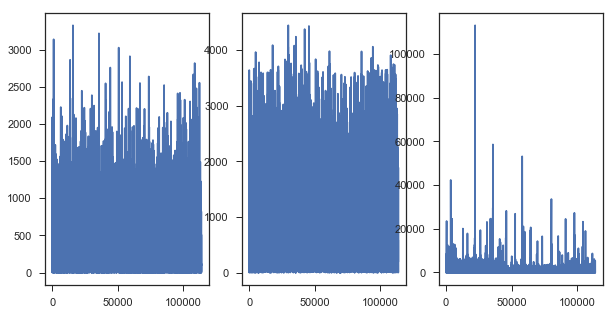

In [33]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,5))

axes[0].plot(ttp)
axes[1].plot(dur)
axes[2].plot(pea)

In [34]:
ttp_n = preprocessing.scale(ttp)
dur_n = preprocessing.scale(dur)
pea_n = preprocessing.scale(pea) 

In [35]:
TTP = fftpack.fft(ttp_n)
DUR = fftpack.fft(dur_n)
PEA = fftpack.fft(pea_n)

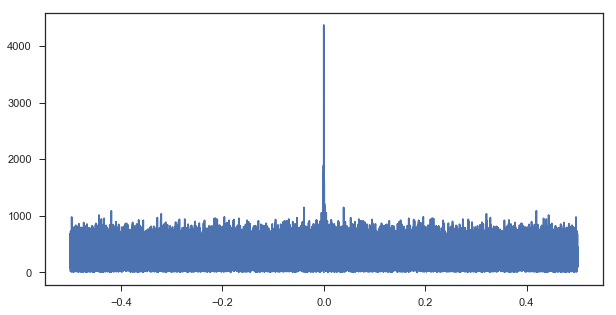

In [36]:
ff = fftpack.fftfreq(len(TTP))*1

plt.figure(figsize=(10,5))
plt.plot(ff,np.abs(TTP))

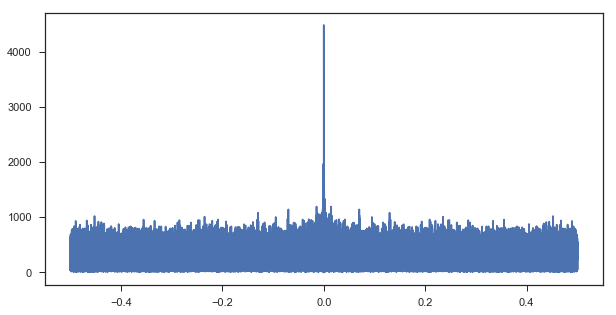

In [37]:
ff = fftpack.fftfreq(len(DUR))*1

plt.figure(figsize=(10,5))
plt.plot(ff,np.abs(DUR))

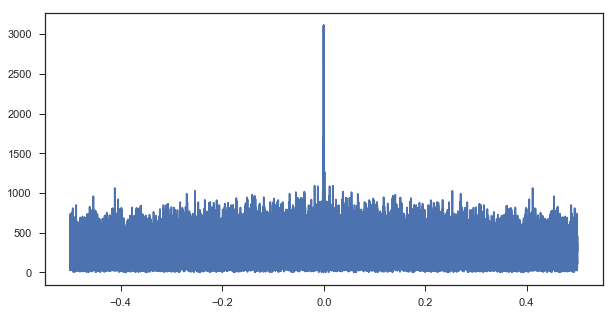

In [38]:
ff = fftpack.fftfreq(len(PEA))*1

plt.figure(figsize=(10,5))
plt.plot(ff,np.abs(PEA))

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

dfpp = dfp.drop('start.date',axis=1)
dfpp = dfpp.drop(['flag.1','flag.2','flag.3','flag.4','flag.5'],axis=1)
data,labels = dfpp,dfpp.pop('energy.kev')

for colname in data.columns:
    data[colname] = preprocessing.StandardScaler().fit_transform(data[colname].values.reshape(-1,1))

data,labels = data.values,pd.get_dummies(labels).values

X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,shuffle=True)

li = Input(shape=(4,))
l1 = Dense(units=50,activation='tanh')(li)
l2 = Dense(units=50,activation='tanh')(l1)
l3 = Dense(units=50,activation='tanh')(l2)
l4 = Dropout(0.1)(l3)
lt = Dense(units=9,activation='softmax')(l4)
model = Model(li,lt)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10,validation_split=0.1)

comp_clf_strat = DummyClassifier(strategy='stratified').fit(X_train,y_train)
comp_clf_mf = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)

Train on 82037 samples, validate on 9116 samples
Epoch 1/10
82037/82037 [==============================] - 6s 69us/step - loss: 0.6302 - acc: 0.8009 - val_loss: 0.5866 - val_acc: 0.8065
Epoch 2/10
82037/82037 [==============================] - 5s 67us/step - loss: 0.5915 - acc: 0.8061 - val_loss: 0.5728 - val_acc: 0.8062
Epoch 3/10
82037/82037 [==============================] - 6s 71us/step - loss: 0.5779 - acc: 0.8096 - val_loss: 0.5686 - val_acc: 0.8066
Epoch 4/10
82037/82037 [==============================] - 6s 73us/step - loss: 0.5702 - acc: 0.8125 - val_loss: 0.5594 - val_acc: 0.8093
Epoch 5/10
82037/82037 [==============================] - 6s 68us/step - loss: 0.5646 - acc: 0.8128 - val_loss: 0.5521 - val_acc: 0.8148
Epoch 6/10
82037/82037 [==============================] - 6s 69us/step - loss: 0.5613 - acc: 0.8136 - val_loss: 0.5590 - val_acc: 0.8107
Epoch 7/10
82037/82037 [==============================] - 6s 70us/step - loss: 0.5592 - acc: 0.8142 - val_loss: 0.5481 - val_acc:

In [47]:
from sklearn.metrics import accuracy_score

real = np.argmax(y_test,axis=1)
pred_nn = np.argmax(model.predict(X_test),axis=1)
pred_dummy_strat = np.argmax(comp_clf_strat.predict(X_test),axis=1)
pred_dummy_mf = np.argmax(comp_clf_mf.predict(X_test),axis=1)

print('NN acc.: %.3f'%accuracy_score(real,pred_nn))
print('Stratified sampling: %.3f'%accuracy_score(real,pred_dummy_strat))
print('Frequency sampling: %.3f'%accuracy_score(real,pred_dummy_mf))

NN acc.: 0.815
Stratified sampling: 0.464
Frequency sampling: 0.751


In [48]:
from sklearn.ensemble import RandomForestClassifier

dfrf = dfp.drop('start.date',axis=1)
dfrf = dfrf.drop(['flag.1','flag.2','flag.3','flag.4','flag.5'],axis=1)
data,labels = dfrf,dfrf.pop('energy.kev')


for colname in data.columns:
    data[colname] = preprocessing.StandardScaler().fit_transform(data[colname].values.reshape(-1,1))
    
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,shuffle=True)

rfc = RandomForestClassifier().fit(X_train,y_train)

real = y_test
pred_rfc = rfc.predict(X_test)

print('RF acc.: %.3f'%accuracy_score(real,pred_rfc))

RF acc.: 0.801


In [100]:
# Next goes the LSTM
lookback = 25

dflstm = dfp.drop(['flag.1','flag.2','flag.3','flag.4','flag.5'],axis=1)
dflstm = dflstm.sort_values(by='start.date')
dflstm_data,dflstm_labels = dflstm.drop('energy.kev',axis=1),pd.get_dummies(dflstm['energy.kev'])
dflstm_data = dflstm_data.drop('start.date',axis=1)

In [112]:
dflstm_labels.values

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [101]:
T = dflstm['energy.kev'].values

In [174]:
DATA = []
LABELS = []

INFO = []

for k in range(lookback,T.shape[0]):
    DATA.append(T[k-lookback:k-1])
    LABELS.append(dflstm_labels.values[k,:])
    
    INFO.append(dflstm_data[['TimeToPeak.s','']].values[k-lookback:k-1])

In [175]:
DATA = StandardScaler().fit_transform(DATA)
INFO = StandardScaler().fit_transform(INFO)

DATA = np.expand_dims(np.vstack(DATA),axis=2)
LABELS = np.vstack(LABELS)
INFO = np.expand_dims(np.vstack(INFO),axis=2)

In [176]:
DATA = np.append(DATA,INFO,axis=2)

In [177]:
Xtrain,Xtest,ytrain,ytest = train_test_split(DATA,LABELS,test_size=0.2,shuffle=False)

In [183]:
model = Sequential()

model.add(LSTM(units=70,input_shape=(DATA.shape[1],DATA.shape[2]),activation=None,return_sequences=True))
model.add(LSTM(units=64,activation=None))
model.add(Dense(25,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(LABELS.shape[1],activation='softmax'))

model.compile(optimizer='adagrad',loss='categorical_crossentropy',metrics=['accuracy'])

In [184]:
model.fit(Xtrain,ytrain,epochs=2,validation_split=0.1)

Train on 82019 samples, validate on 9114 samples
Epoch 1/2
82019/82019 [==============================] - 123s 1ms/step - loss: 4.9012 - acc: 0.6947 - val_loss: 3.2982 - val_acc: 0.7954
Epoch 2/2
82019/82019 [==============================] - 131s 2ms/step - loss: 3.9160 - acc: 0.7570 - val_loss: 3.2977 - val_acc: 0.7954


In [180]:
real = np.argmax(ytest,axis=1)
pred_lstm = np.argmax(model.predict(Xtest),axis=1)

print('NN acc.: %.3f'%accuracy_score(real,pred_lstm))

NN acc.: 0.717
